# Painting Date Estimator

Goal of the project is developing a machine learning algorithm which is able to estimating the year in which a painting has been created, based on its appearance only. 

This code has been developed as Capstone Project for the Coursera's [Advanced Data Science with IBM Specialization](https://www.coursera.org/specializations/advanced-data-science-ibm).

In the current Notebook we will just present the Dataset and the obtained results, using a subset of the available images. Model can be trained following the information in [Readme](../readme.md).

## Dataset Description
[Painter by Numbers](https://www.kaggle.com/c/painter-by-numbers) Kaggle Dataset has originaly been collected for "*identifying an authentic work of art from a forgery*". It is rich of data, including annotations about painter, style, genre and date. 

Considering the scenario we are interested in, many of the annotations will not be used and some of the available paintings cannot be used, due to unknown creation date.

## Notebook configuration
Let's install the required packages, include the required classes and configure Spark before diving in dataset exploration.

In [1]:
# Modifying notebook width for better fitting SQLs
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Installing the dependencies
#!pip install -r ../requirements.txt

# Importing the required libraries
from pyspark import *
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
import numpy as np

# Importing utility functions
import sys
sys.path.append('../src/')
import utils

import PIL
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000  
print('PIL',PIL.__version__)

%matplotlib inline

PIL 7.0.0


In [2]:
# Configuring Spark
conf = SparkConf().setAppName("Artist Detector")
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)

## Downloading the data and setting folders path
Data can be downloaded from [Painter by Numbers](https://www.kaggle.com/c/painter-by-numbers) Kaggle competition, 
after registerng to Kaggle and joining the competition.

* Copy _all_data_info.csv_ in _'./data/'_ folder;
* Extract the images in _'./data/train'_ and _'./data/test'_ folders. 


In [3]:
csv_path = "../data/all_data_info.csv" 
image_base_dir_train_val = '../data/train/'
image_base_dir_test = '../data/test/'

## Data Exploration
### Dataset structure
Let's take a look to the dataset and visualize its structure, some of the entries and their total number.

In [4]:
# Read Input File
df = sqlContext.read.format("csv").option("header", "true").load(csv_path)

# Initialize SQL View
df.createOrReplaceTempView('artists')

print('DATABASE FIELDS:  ')
df.printSchema()

print('\nTABLE ENTRIES:  ')
df.show()

print('\nNUMBER OF ENTRIES: {}'.format(df.count()))

DATABASE FIELDS:  
root
 |-- artist: string (nullable = true)
 |-- date: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- pixelsx: string (nullable = true)
 |-- pixelsy: string (nullable = true)
 |-- size_bytes: string (nullable = true)
 |-- source: string (nullable = true)
 |-- style: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist_group: string (nullable = true)
 |-- in_train: string (nullable = true)
 |-- new_filename: string (nullable = true)


TABLE ENTRIES:  
+--------------------+------+--------------------+-------+-------+----------+-------+--------------------+--------------------+--------------+--------+------------+
|              artist|  date|               genre|pixelsx|pixelsy|size_bytes| source|               style|               title|  artist_group|in_train|new_filename|
+--------------------+------+--------------------+-------+-------+----------+-------+--------------------+--------------------+--------------+--------+-----

The table requires some preprocessing activities since:
* Many colums are not needed for my analysis (i.e. pixelsx, pixelsy, size_bytes, source, ...);
* Some entries have missing date ('*null*' entry);
* Format types should be fixed (_date_ column format type is set as _string_ );
* Data entries are not homogeneous: some of them represents textual information, some others represent integer and some represents floating numbers.  

### Dataset statistics
We can notice that the database is already split in train set and test set thanks to the _in_train_ column. 

This split is fundamental not only for organizing the training of the algorithm, but also to correctly load the data. 

Let's analyze how many elements each one of the splits have.

In [5]:
# Splitting train and test sets
df_train = sqlContext.sql("""SELECT * from artists where in_train='True'""")
df_train.createOrReplaceTempView('train_set')
print('\nNUMBER OF TRAIN ENTRIES: {}'.format(df_train.count()))

df_test = sqlContext.sql("""SELECT * from artists where in_train='False'""")
df_test.createOrReplaceTempView('test_set')
print('NUMBER OF TEST ENTRIES:  {}'.format(df_test.count()))


NUMBER OF TRAIN ENTRIES: 79416
NUMBER OF TEST ENTRIES:  23813


## DATE Distribution Analysis
Let's verify the date distribution, listing the most common ones and plotting the histogram.

+----+--------------+
|date|num_of_entries|
+----+--------------+
|null|         20251|
|1913|           448|
|1912|           441|
|1910|           418|
|1914|           406|
|1908|           389|
|1911|           351|
|1907|           348|
|1888|           347|
|1890|           346|
|1915|           343|
|1885|           329|
|1909|           326|
|1917|           322|
|1895|           318|
|1934|           312|
|1889|           305|
|1920|           305|
|1884|           304|
|1906|           303|
+----+--------------+
only showing top 20 rows



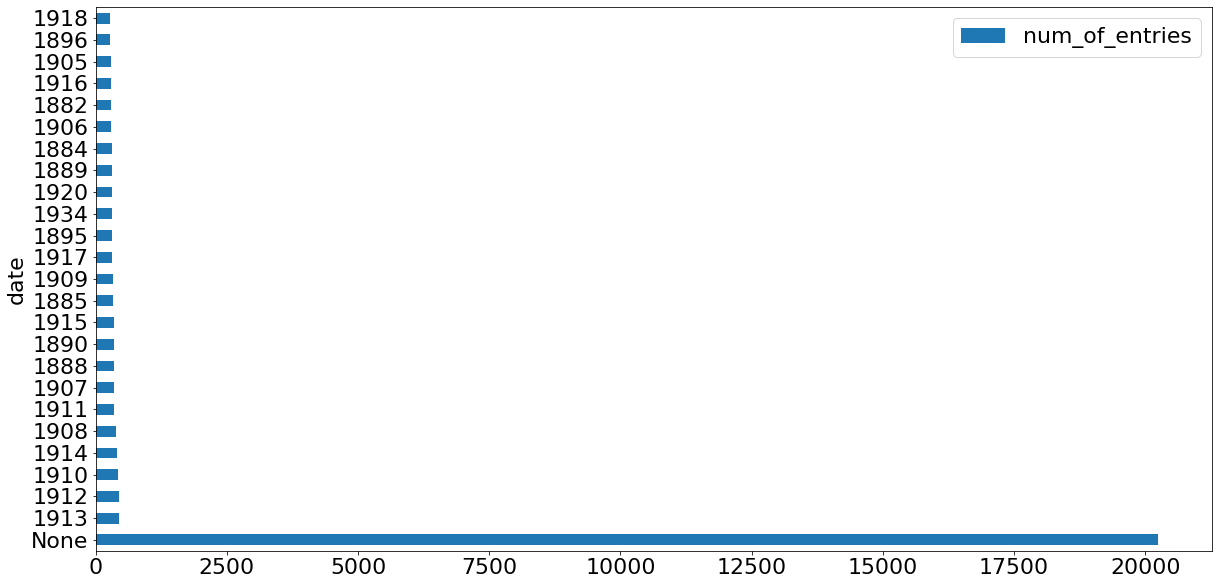

In [6]:
# Listing the most represented date
df_date = sqlContext.sql("""SELECT date, count(*) as num_of_entries from train_set GROUP BY date ORDER BY num_of_entries desc""")
df_date.createOrReplaceTempView('df_genre')
df_date.show()

# Histogram of date
pandas_df_date = df_date.limit(25).toPandas()
utils.plotHistogram(pandas_df_date)

As we can notice, the most represented date is _None_, i.e. many paintings do not have a labelled date.

We have to clean the data before obtaining reliable results:
* Removing _None_ entries;
* Purging non numerical information from the date;
* Casting date to int when float;
* Casting int date to float for correctly feed the data to the machine learning algorithm.

In [7]:
# Date cleansing function
from pyspark.sql.types import FloatType
import re

def keep_date_only(x):
    try:
        return int(x)
    except ValueError:
        try:
            return float(int(float(x)))
        except ValueError:
            kdo = re.sub("[^0-9]", "", x)
            if len(kdo)>0:
                return float(kdo)
            
sqlContext.udf.register("kdo", lambda s: keep_date_only(s), FloatType())

# We have to use kdo function twice in order to correctly group the date when they have been labelled differently even if representing the same date (i.e. 1880 and c.1880)
# ALL
df_date_all_ori = sqlContext.sql("""SELECT date, kdo(date) as kdo_date from artists where date is not null ORDER BY date""")
df_date_all_ori.createOrReplaceTempView('date_all')
df_date_all = sqlContext.sql("""SELECT kdo_date as date, count(*) as num_of_entries from date_all where kdo_date is not null and kdo_date > 1000 GROUP BY kdo_date ORDER BY kdo_date""")

# TRAIN
df_date_train_ori = sqlContext.sql("""SELECT date, kdo(date) as kdo_date from train_set where date is not null ORDER BY date""")
df_date_train_ori.createOrReplaceTempView('date_train')
df_date_train = sqlContext.sql("""SELECT kdo_date as date, count(*) as num_of_entries from date_train where kdo_date is not null and kdo_date > 1000 GROUP BY kdo_date ORDER BY kdo_date""")

# TEST
df_date_test_ori = sqlContext.sql("""SELECT date, kdo(date) as kdo_date from test_set where date is not null ORDER BY date""")
df_date_test_ori.createOrReplaceTempView('date_test')
df_date_test = sqlContext.sql("""SELECT kdo_date as date, count(*) as num_of_entries from date_test where kdo_date is not null and kdo_date > 1000 GROUP BY kdo_date ORDER BY kdo_date""")

We convert the pySpark dataframe in Pandas dataframe for conveniently plotting them.

We also plot a painting for each of the 5 most represented dates in the dataset.

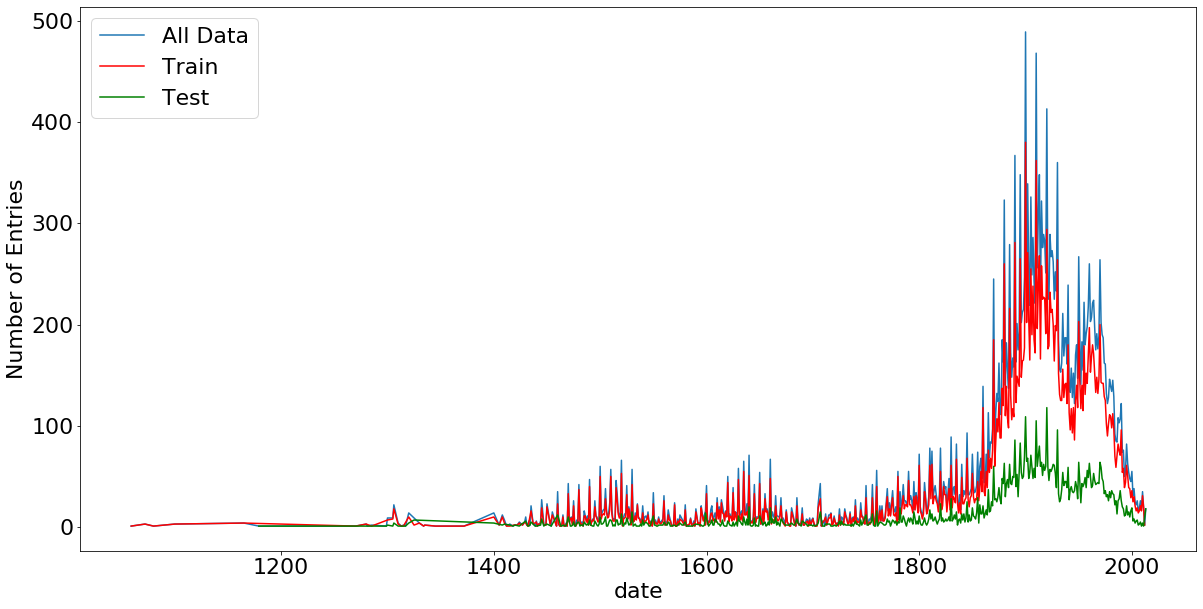

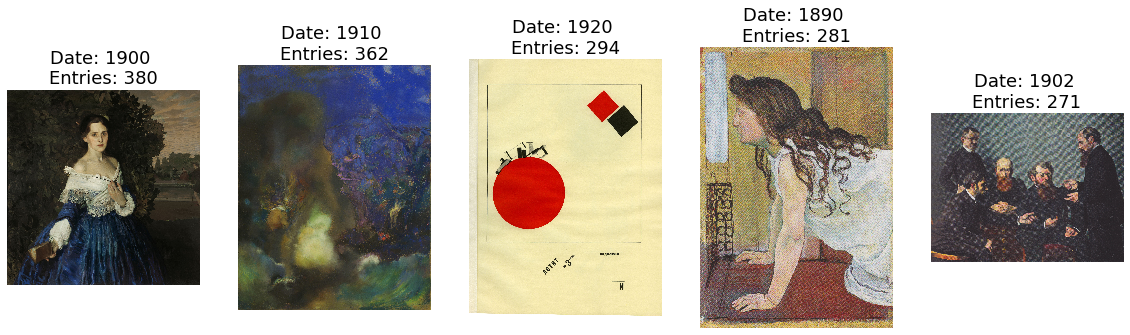

In [8]:
pandas_df_date_all = df_date_all.toPandas()
pandas_df_date_train = df_date_train.toPandas()
pandas_df_date_test = df_date_test.toPandas()

# Plotting data distribution
ax = pandas_df_date_all.plot(x='date', y='num_of_entries')
pandas_df_date_train.plot(x='date', y='num_of_entries', color='red', ax=ax)
pandas_df_date_test.plot(x='date', y='num_of_entries', color='green', ax=ax)
ax.set_ylabel("Number of Entries")
ax.legend(["All Data", "Train", "Test"]);
plt.show()

# Visualize a painting from the 5 most represented dates in train set
df_date_train_sorted = sqlContext.sql("""SELECT kdo_date as date, count(*) as num_of_entries from date_train where kdo_date is not null GROUP BY kdo_date ORDER BY num_of_entries desc""")
pandas_df_date_train_sorted = df_date_train_sorted.toPandas()

plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 15})
fig = plt.figure()
for idx in range(5):
    date_name = str(int(pandas_df_date_train_sorted.iloc[idx].date))
    noe = str(int(pandas_df_date_train_sorted.iloc[idx].num_of_entries))
    df_img_path = image_base_dir_train_val + df_train.filter(df_train['date'] == date_name).head().new_filename

    img = Image.open(df_img_path)

    sub_plt = fig.add_subplot(1, 5, idx+1)
    imgplot = plt.imshow(img)
    sub_plt.set_title("Date: {} \nEntries: {}".format(date_name, noe))
    sub_plt.axis('off')

Paintings with date prior than 1800 are very barely represented in comparison to the most recent paintings. We can notice a peak on each decade: very likely many annotations have been approximated.

Train and test painting date distribution is very similar.

## ARTISTS distribution analysis
Similarly to what have been done for DATA analysis, let's check the most common artists in the dataset.

+--------------------+--------------+
|              artist|num_of_entries|
+--------------------+--------------+
|        Paul Cezanne|           412|
|Giovanni Battista...|           402|
|     Martiros Saryan|           399|
|          Ilya Repin|           397|
|    Camille Pissarro|           393|
|    Vincent van Gogh|           392|
|  Theophile Steinlen|           389|
|     Boris Kustodiev|           388|
|Pierre-Auguste Re...|           388|
|  Pyotr Konchalovsky|           388|
|       Eugene Boudin|           387|
|         Edgar Degas|           387|
|       Camille Corot|           387|
|        Gustave Dore|           387|
|       Henri Matisse|           384|
|        Claude Monet|           383|
|      Albrecht Durer|           379|
|     Ivan Aivazovsky|           378|
|       Pablo Picasso|           377|
| John Singer Sargent|           377|
+--------------------+--------------+
only showing top 20 rows



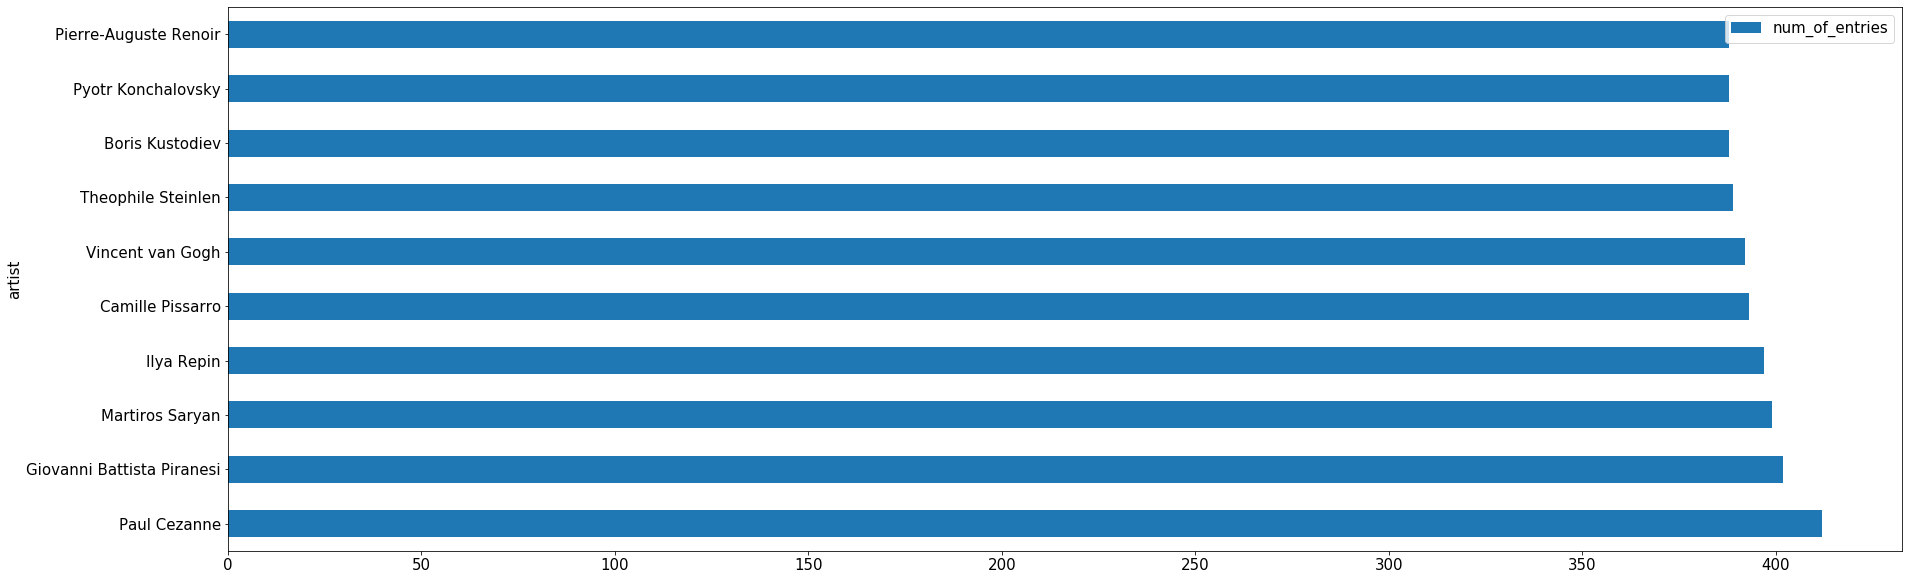

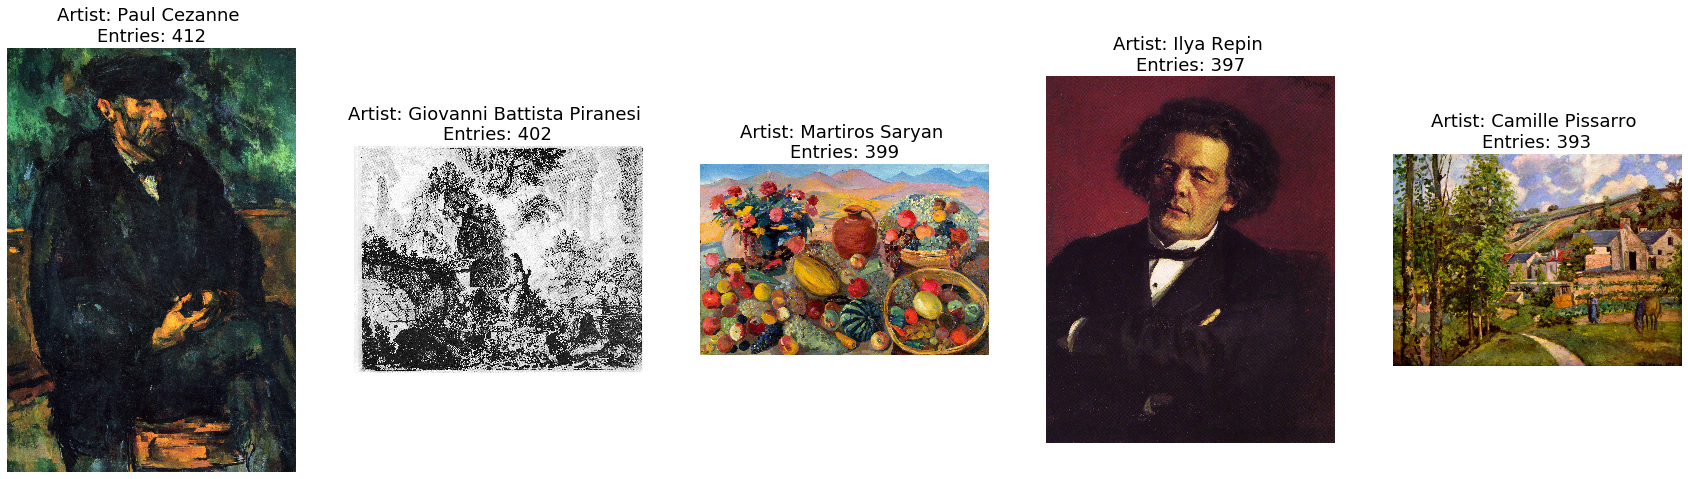

In [9]:
# Listing most represented artists in train set
df_artist_name = sqlContext.sql("""SELECT artist, count(*) as num_of_entries from train_set GROUP BY artist ORDER BY num_of_entries desc""")
df_artist_name.createOrReplaceTempView('df_artist_name')
df_artist_name.show()

# Histogram of artists
plt.rcParams['figure.figsize'] = [30, 10]
pandas_df_artist_name = df_artist_name.limit(10).toPandas()
pandas_df_artist_name.plot(kind='barh', x='artist', y='num_of_entries')
plt.show()

# Visualize a painting from the 5 most represented artists
plt.rcParams['figure.figsize'] = [30, 30]
plt.rcParams.update({'font.size': 15})

fig = plt.figure()
for idx in range(5):
    artist_name = pandas_df_artist_name.iloc[idx].artist
    noe = str(int(pandas_df_artist_name.iloc[idx].num_of_entries))
    df_img_path = image_base_dir_train_val + df_train.filter(df['artist'] == artist_name).head().new_filename

    img = Image.open(df_img_path)

    sub_plt = fig.add_subplot(1, 5, idx+1)
    imgplot = plt.imshow(img)
    sub_plt.set_title("Artist: {} \nEntries: {}".format(artist_name, noe))
    sub_plt.axis('off')

### GENRE distribution analysis
We finally check the genre distribution in the dataset.

+--------------------+--------------+
|               genre|num_of_entries|
+--------------------+--------------+
|            portrait|         12926|
|           landscape|         11548|
|      genre painting|         10983|
|            abstract|          7201|
|  religious painting|          5703|
|           cityscape|          4089|
|    sketch and study|          2772|
|        illustration|          2490|
|          still life|          2461|
|   symbolic painting|          1959|
|          figurative|          1782|
|  nude painting (nu)|          1757|
|              design|          1577|
|mythological pain...|          1493|
|              marina|          1385|
|     flower painting|          1270|
|     animal painting|          1233|
|       self-portrait|          1199|
|                null|           893|
|allegorical painting|           808|
+--------------------+--------------+
only showing top 20 rows



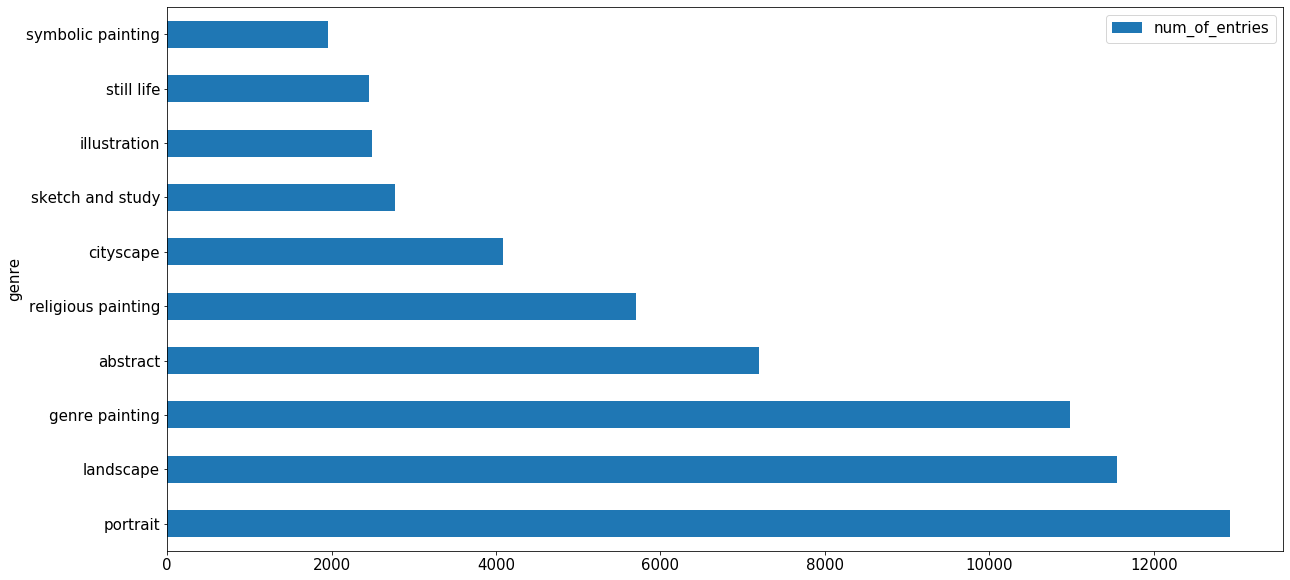

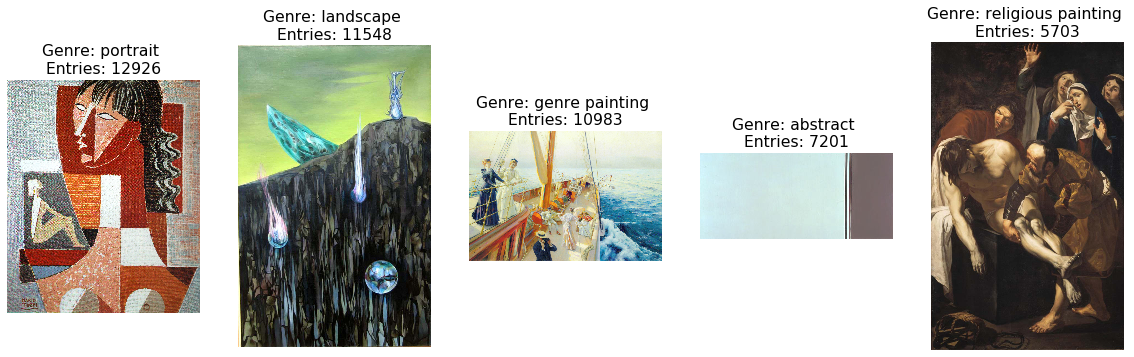

In [10]:
# Listing most represented generes
df_genre = sqlContext.sql("""SELECT genre, count(*) as num_of_entries from train_set GROUP BY genre ORDER BY num_of_entries desc""")
df_genre.createOrReplaceTempView('df_genre')
df_genre.show()

# Histogram of generes
plt.rcParams['figure.figsize'] = [20, 10]
pandas_df_genre = df_genre.limit(10).toPandas()
pandas_df_genre.plot(kind='barh', x='genre', y='num_of_entries')
plt.show()

# Visualize a painting from the 5 most represented genre
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 13})

fig = plt.figure()
for idx in range(5):
    genre_name = pandas_df_genre.iloc[idx].genre
    noe = str(int(pandas_df_genre.iloc[idx].num_of_entries))
    df_img_path = image_base_dir_train_val + df_train.filter(df['genre'] == genre_name).head().new_filename

    img = Image.open(df_img_path)

    sub_plt = fig.add_subplot(1, 5, idx+1)
    imgplot = plt.imshow(img)
    sub_plt.set_title("Genre: {} \nEntries: {}".format(genre_name, noe))    
    sub_plt.axis('off')

## ETL: Data Preparation
After having understood the data, we generate a dataframe containing only the relevant information. Dates have been normalized subtracting the mean and dividing the standard deviation in order to be ready for feeding in our Machine Learning model. 

The database contains some corrupted images. The most strainghtforward way for dealing with them is managing the corrupted images during loading.

In [11]:
# Generating Train Validation and Test Set
train_val_df_ori = sqlContext.sql("""SELECT date, kdo(date) as kdo_date, new_filename from train_set where date is not null""")
train_val_df_ori.createOrReplaceTempView('train_val_df_ori')
train_val_df = sqlContext.sql("""SELECT kdo_date as date, new_filename as filename from train_val_df_ori where kdo_date is not null and kdo_date > 1000 """)

test_df_ori = sqlContext.sql("""SELECT date, kdo(date) as kdo_date, new_filename from test_set where date is not null""")
test_df_ori.createOrReplaceTempView('test_df_ori')
test_df = sqlContext.sql("""SELECT kdo_date as date, new_filename as filename from test_df_ori where kdo_date is not null and kdo_date > 1000 """)

# Converting to Pandas
p_test_df = test_df.toPandas()
p_train_val_df = train_val_df.toPandas()

p_train_df = p_train_val_df.sample(frac=0.8,random_state=200) #random state is a seed value
p_val_df = p_train_val_df.drop(p_train_df.index)

# Let's print some statistiscs
print('TRAINING FIELDS & TYPES:  ')
train_val_df.printSchema()

print('\nTRAINING ENTRIES:  {}'.format(len(p_train_df)))
print('VALIDATIO ENTRIES: {}'.format(len(p_val_df)))
print('TEST ENTRIES:      {}'.format(len(p_test_df)))

# Let's normalize the dates
# Train date mean and std
train_date_mean = np.mean(p_train_df.date)
train_date_std = np.std(p_train_df.date)
print('\nTRAINING DATES MEAN: {:.4f}'.format(train_date_mean))
print('TRAINING DATES STD:  {:.4f}'.format(train_date_std))

p_train_df.date = (p_train_df.date-train_date_mean)/train_date_std
p_val_df.date = (p_val_df.date-train_date_mean)/train_date_std
p_test_df.date = (p_test_df.date-train_date_mean)/train_date_std
print('\nNormalized data:')
print('TRAINING DATES - UPDATED MEAN: {:.4f} - UPDATED STD: {:.4f}'.format(np.mean(p_train_df.date), np.std(p_train_df.date)))

TRAINING FIELDS & TYPES:  
root
 |-- date: float (nullable = true)
 |-- filename: string (nullable = true)


TRAINING ENTRIES:  20674
VALIDATIO ENTRIES: 5168
TEST ENTRIES:      7835

TRAINING DATES MEAN: 1874.7548
TRAINING DATES STD:  121.9153

Normalized data:
TRAINING DATES - UPDATED MEAN: -0.0000 - UPDATED STD: 1.0000


## PyTorch Dataset and Dataloaders definition

In [12]:
# Importing the relevant pyTorch functionalities for data management and training
import torch
from torch import manual_seed
from torch.utils.data import DataLoader
from torchvision import transforms

# Importing pyTorch custom Dataset and Model
from dataset import PaintersDataset
from model import Resnet152_fc

manual_seed(699);

In [13]:
# Defining the required data augmentation algorithms
img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

image_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(int(1.1 * image_size)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)
    ]),
}

In [14]:
# Initializing pyTorch Dataloaders
base_dir_train_val = '../data/train/'
base_dir_test = '../data/test/'
batch_size = 16

painter_dataset = {}
painter_dataset['train'] = PaintersDataset(p_train_df, base_dir_train_val, data_transforms['train'])
painter_dataset['val'] = PaintersDataset(p_val_df, base_dir_train_val, data_transforms['val'])
painter_dataset['test'] = PaintersDataset(p_test_df, base_dir_test, data_transforms['val'])

dataloaders = {}
dataloaders['train'] = DataLoader(painter_dataset['train'], batch_size=batch_size, shuffle=True, num_workers=4) 
dataloaders['val'] = DataLoader(painter_dataset['val'], batch_size=batch_size, shuffle=True, num_workers=4) 
dataloaders['test'] = DataLoader(painter_dataset['test'], batch_size=batch_size, shuffle=True, num_workers=4) 

### Dataset and Dataloader check
Let's verify Dataloaders are properly working.

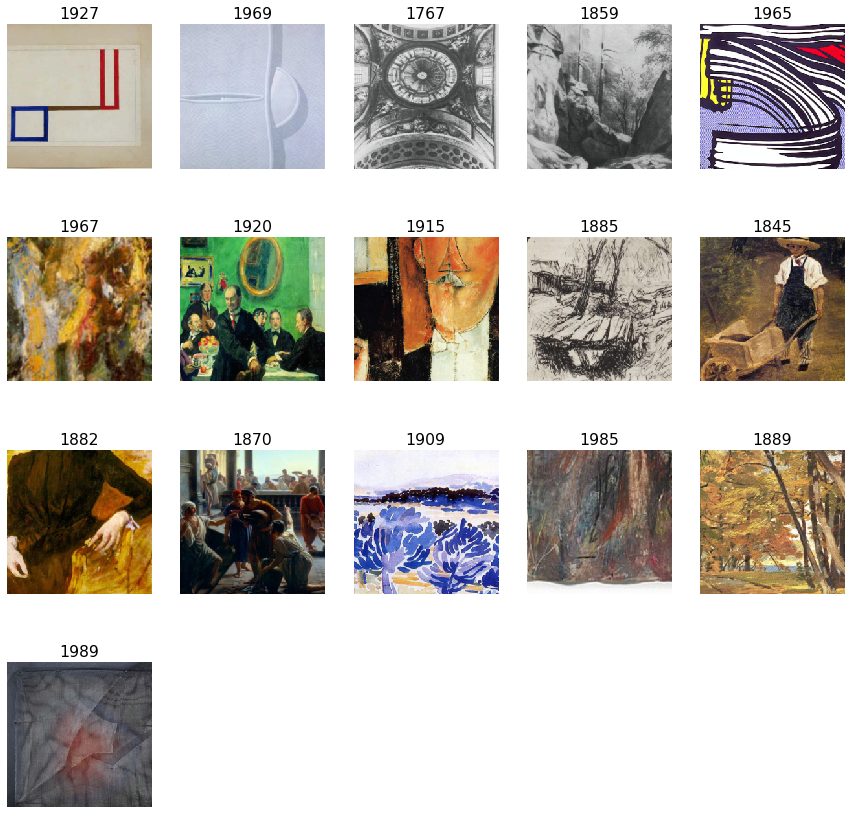

In [15]:
# Get a batch of training data
imgs, classes, idx = next(iter(dataloaders['train']))

utils.show_batch(imgs, classes, img_mean, img_std, train_date_mean, train_date_std)

## Model Definition
We use a fully convolutional implementation of ResNet 152 to produce a single valued output.

In [16]:
# Let's initialize the device, in order to be able to train on GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Let' s initialize the model
net = Resnet152_fc(1)

## Model Evaluation
Let's verify some of the outputs generated by the best trained model and quantify the estimation error.

### Qualitative evaluation

<Figure size 1440x720 with 0 Axes>

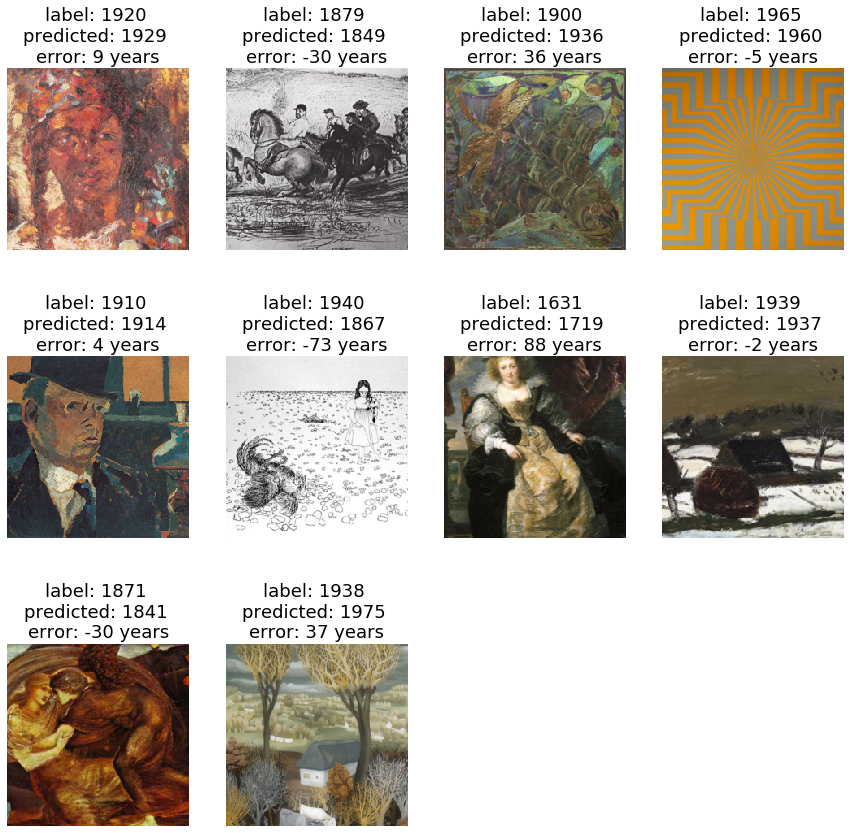

In [17]:
# Let's visualize some results on the test set and corresponding errors
model_path = '../models_pretrained/'
model_filename = model_path + 'best_resnet152.pth'

checkpoint = torch.load(model_filename)
net.load_state_dict(checkpoint['state_dict'])
net.to(device)

utils.visualize_model_results(net, device, dataloaders['test'], img_mean, img_std, train_date_mean, train_date_std)

### Quantitative evaluation

In [18]:
# Let's evaluate the model on the test set
test_filenames, test_labels, test_preds = utils.evaluate_model(net, device, dataloaders['test'], train_date_mean, train_date_std)

# Let' s convert the results in numpy vectors
test_filenames_np = utils.tensor_str_vec_to_numpy(test_filenames)
test_labels_np = utils.tensor_num_vec_to_numpy(test_labels)
test_preds_np = utils.tensor_num_vec_to_numpy(test_preds)

Iteration   10 out of 490 (2.04%) - cycle time: 1.8228 - elapsed time: 1.8228
Iteration   20 out of 490 (4.08%) - cycle time: 3.0445 - elapsed time: 3.0445
Iteration   30 out of 490 (6.12%) - cycle time: 5.8201 - elapsed time: 5.8201
Iteration   40 out of 490 (8.16%) - cycle time: 7.1162 - elapsed time: 7.1162
Iteration   50 out of 490 (10.20%) - cycle time: 11.7406 - elapsed time: 11.7406
Iteration   60 out of 490 (12.24%) - cycle time: 12.8521 - elapsed time: 12.8521
Iteration   70 out of 490 (14.29%) - cycle time: 14.2418 - elapsed time: 14.2418
Iteration   80 out of 490 (16.33%) - cycle time: 15.4898 - elapsed time: 15.4898
Iteration   90 out of 490 (18.37%) - cycle time: 16.7578 - elapsed time: 16.7578
Iteration  100 out of 490 (20.41%) - cycle time: 18.1754 - elapsed time: 18.1754
Iteration  110 out of 490 (22.45%) - cycle time: 20.3544 - elapsed time: 20.3544
Iteration  120 out of 490 (24.49%) - cycle time: 22.4050 - elapsed time: 22.4050
Iteration  130 out of 490 (26.53%) - cyc

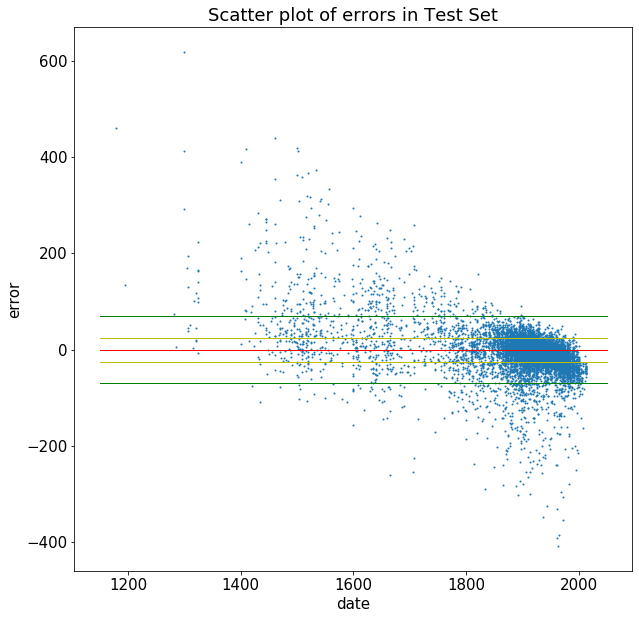

In [19]:
# Let's plot the errors as a function of painting date in TEST set
test_err_np = test_preds_np - test_labels_np

plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(test_labels_np, test_err_np, s=1)
plt.plot([1150, 2050], [0, 0], 'k-', color = 'r', linewidth=1)
plt.plot([1150, 2050], [25, 25], 'k-', color = 'y', linewidth=1)
plt.plot([1150, 2050], [-25, -25], 'k-', color = 'y', linewidth=1)
plt.plot([1150, 2050], [70, 70], 'k-', color = 'g', linewidth=1)
plt.plot([1150, 2050], [-70, -70], 'k-', color = 'g', linewidth=1)
plt.title('Scatter plot of errors in Test Set')
plt.xlabel('date')
plt.ylabel('error')
plt.show()

* Magenta lines represents the label value;
* Yellow lines represent +/- 25 years error;
* Green  lines represent +/- 70 years error.

In [20]:
print("Median error: {0:.2f} years.\n".format(np.median(np.absolute(test_err_np))))

for i in range(20):
    print("Error minor than {} years: {:.2f} %".format((i+1)*5, 100*(np.absolute(test_err_np) < (i+1)*5).sum()/len(test_err_np)))

Median error: 20.92 years.

Error minor than 5 years: 13.03 %
Error minor than 10 years: 25.35 %
Error minor than 15 years: 37.65 %
Error minor than 20 years: 48.19 %
Error minor than 25 years: 56.91 %
Error minor than 30 years: 63.96 %
Error minor than 35 years: 70.12 %
Error minor than 40 years: 74.72 %
Error minor than 45 years: 78.77 %
Error minor than 50 years: 81.98 %
Error minor than 55 years: 84.28 %
Error minor than 60 years: 86.25 %
Error minor than 65 years: 87.65 %
Error minor than 70 years: 88.92 %
Error minor than 75 years: 90.02 %
Error minor than 80 years: 90.70 %
Error minor than 85 years: 91.64 %
Error minor than 90 years: 92.33 %
Error minor than 95 years: 93.03 %
Error minor than 100 years: 93.67 %
